# Main

In [69]:
import mydatasets
import mymodels
import utils
import DML
import numpy as np
import torch
import torch.nn.functional as F
import copy
import sys
import os
import json 
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from torchinfo import summary
import pickle

In [2]:
ttt = torch.rand(10,8,3)
mmm = torch.nn.Conv1d(3,1,2)

In [3]:
mmm(ttt.permute(0,2,1)).shape

torch.Size([10, 1, 7])

In [4]:
ttt2 = torch.rand(500,200, 20)
mmm2 = torch.nn.Conv1d(20, 8, kernel_size=3, padding='same')

In [5]:
mmm2(ttt2.permute(0,2,1)).permute(0,2,1).shape

torch.Size([500, 200, 8])

In [6]:
ttt.permute(0,2,1).shape

torch.Size([10, 3, 8])

In [7]:
X = pd.read_csv('../data/gene_data.csv', header=None, index_col=0)
X

,1,2,3,4,5,6,7,8,9,10,...,3958,3959,3960,3961,3962,3963,3964,3965,3966,3967
0,,,,,,,,,,,,,,,,,,,,,
SRR1166318,0,0,1,0,0,4,0,0,0,1,...,0,0,1,1,0,0,0,0,0,0
ERR176810,0,0,1,0,2,3,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
ERR181956,0,0,1,0,1,3,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
SRR2100379,0,0,1,0,0,4,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
SRR924706,0,0,1,0,2,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR671746,0,0,1,0,0,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
SRR1146372,0,0,2,0,0,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
ERR176477,0,0,1,0,1,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [8]:
Y = pd.read_csv('../data/AllLabels.csv', index_col='id')
Y = Y[Y.index.isin(X.index)]
Y

,amikacin,capreomycin,ciprofloxacin,ethambutol,ethionamide,isoniazid,kanamycin,moxifloxacin,ofloxacin,pyrazinamide,rifampicin,streptomycin
id,,,,,,,,,,,,
SRR3675211,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN
SRR3675215,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN
SRR3675217,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,0.0,1.0,NaN
SRR3675218,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,0.0,NaN
SRR3675224,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
SRR924705,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
SRR924706,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
SRR924707,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0


In [9]:
NoYs = X[np.logical_not(X.index.isin(Y.index))]
print('Xs with no Y found:', NoYs.shape[0])
X = X.drop(NoYs.index)

Xs with no Y found: 115


In [10]:
X = X.sort_index().reset_index().rename(columns={0: 'id'})
Y = Y.sort_index().reset_index()

In [11]:
X_mat = X.iloc[:, 1:].to_numpy()
Y_mat = Y.iloc[:, 1:].to_numpy()

In [12]:
#Test
np.nansum(Y_mat[150] * Y_mat[500])

1.0

In [13]:
#Test
nonz = 0
for i in range(Y_mat.shape[0]):
    nonz += np.sum(np.nansum(Y_mat * Y_mat[i], axis=1) != 0)
(nonz/2) / (7845*7845)

0.1073278762641865

In [14]:
#Test
nonz2 = 0
for i in range(Y_mat.shape[0]):
    nonz2 += np.sum(Y_mat == Y_mat[i])
(nonz2 /2) / (7845*7845)

1.0149688860941415

In [15]:
#Test
(Y_mat[0] - Y_mat[1])**2

array([nan, nan, nan,  0., nan,  0., nan, nan, nan, nan,  0.,  0.])

In [16]:
#Test
a = np.array([
    [1, 9, 7, 1, 1],
    [6, np.nan, 3, 9, 0],
    [1, 8, 6, np.nan, 1],
    [7, 4, 0, 5, 3]])
np.nanmean(a, axis=0)

array([3.75, 7.  , 4.  , 5.  , 1.25])

In [17]:
a.tolist()

[[1.0, 9.0, 7.0, 1.0, 1.0],
 [6.0, nan, 3.0, 9.0, 0.0],
 [1.0, 8.0, 6.0, nan, 1.0],
 [7.0, 4.0, 0.0, 5.0, 3.0]]

In [18]:
np.nonzero(a.flatten())

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 18,
        19]),)

In [19]:
for i in range(5):
    print(i)

0
1
2
3
4


In [20]:
np.sort(1-a)

array([[-8., -6.,  0.,  0.,  0.],
       [-8., -5., -2.,  1., nan],
       [-7., -5.,  0.,  0., nan],
       [-6., -4., -3., -2.,  1.]])

In [21]:
#Test - Data for each column
np.sum(np.logical_not(np.isnan(Y_mat)), axis=0)

array([2033, 1991,  443, 6096, 1516, 7734, 2436,  961, 2911, 3858, 7715,
       5125])

In [22]:
#Test - Rows with all zeros
np.sum(np.all(np.logical_or(Y_mat == 0, np.isnan(Y_mat)), axis=1))

4056

In [23]:
# X_mat = PCA(n_components=250).fit_transform(X_mat)

In [24]:
val_test_count = int(X_mat.shape[0] * 0.1)
val_test_indcs = (np.random.permutation(X_mat.shape[0])[:2*val_test_count]).reshape((2, -1))

X_val = X_mat[val_test_indcs[0], :]
Y_val = Y_mat[val_test_indcs[0], :]

X_test = X_mat[val_test_indcs[1], :]
Y_test = Y_mat[val_test_indcs[1], :]

X_train = np.delete(X_mat, val_test_indcs.flatten(), axis=0)
Y_train = np.delete(Y_mat, val_test_indcs.flatten(), axis=0)
print(f'Train Count: {X_train.shape[0]}')
print(f'Validation Count: {X_val.shape[0]}')
print(f'Test Count: {X_test.shape[0]}')

shuffle_indcs = np.random.permutation(X_train.shape[0])
X_train = X_train[shuffle_indcs, :]
Y_train = Y_train[shuffle_indcs, :]

Train Count: 6277
Validation Count: 784
Test Count: 784


In [25]:
def get_roc(x_train: np.ndarray, y_train: np.ndarray, x_eval: np.ndarray, y_eval: np.ndarray, model, n_neighbors=5):
    emb_train = model(torch.from_numpy(x_train.astype('float32'))).detach().numpy()
    emb_val = model(torch.from_numpy(x_eval.astype('float32'))).detach().numpy()
    KNN = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(emb_train)

    nbr_dists, nbr_indcs = KNN.kneighbors(emb_val)
    y_k_neghbors = y_train[nbr_indcs, :]
    y_pred = np.nanmean(y_k_neghbors, axis=1)
    y_pred[np.where(np.isnan(y_pred))] = 0.5
    #y_pred = np.round(y_pred)

    condition = np.where(np.logical_and(np.logical_not(np.isnan(y_eval)), np.logical_not(np.isnan(y_pred))))

    #### CALCULATE ROC

    #return np.sum(y_pred[condition] == y_eval[condition]) / y_eval[condition].shape[0]

In [26]:
def get_acc(x_train: np.ndarray, y_train: np.ndarray, x_eval: np.ndarray, y_eval: np.ndarray, model, n_neighbors=5):
    emb_train = model(torch.from_numpy(x_train.astype('float32'))).detach().numpy()
    emb_val = model(torch.from_numpy(x_eval.astype('float32'))).detach().numpy()
    KNN = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(emb_train)

    nbr_dists, nbr_indcs = KNN.kneighbors(emb_val)
    y_k_neghbors = y_train[nbr_indcs, :] #y_eval x 5 x 12
    y_pred = np.nanmean(y_k_neghbors, axis=1) #y_eval x 12
    y_pred = np.round(y_pred) #0.5 > --> 1

    condition = np.where(np.logical_and(np.logical_not(np.isnan(y_eval)), np.logical_not(np.isnan(y_pred))))

    return np.sum(y_pred[condition] == y_eval[condition]) / y_eval[condition].shape[0]

In [27]:
def get_acc_weighted(x_train: np.ndarray, y_train: np.ndarray, x_eval: np.ndarray, y_eval: np.ndarray, model, n_neighbors=5):
    emb_train = model(torch.from_numpy(x_train.astype('float32'))).detach().numpy()
    emb_val = model(torch.from_numpy(x_eval.astype('float32'))).detach().numpy()
    KNN = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(emb_train)

    nbr_dists, nbr_indcs = KNN.kneighbors(emb_val)
    nbr_weights = np.exp(-nbr_dists)
    y_k_neghbors = y_train[nbr_indcs, :] #y_eval x 5 x 12
    y_k_neighbors_weighted = y_k_neghbors * nbr_weights.reshape(-1, n_neighbors, 1)
    #y_pred = np.nanmean(y_k_neighbors_weighted, axis=1) #y_eval x 12
    y_pred = np.nansum(y_k_neighbors_weighted, axis=1) / np.sum(nbr_weights.reshape(-1, n_neighbors, 1), axis=1)
    y_pred = np.round(y_pred) #0.5 > --> 1

    condition = np.where(np.logical_and(np.logical_not(np.isnan(y_eval)), np.logical_not(np.isnan(y_pred))))

    return np.sum(y_pred[condition] == y_eval[condition]) / y_eval[condition].shape[0]

In [28]:
def get_acc_per_drug(x_train: np.ndarray, y_train: np.ndarray, x_eval: np.ndarray, y_eval: np.ndarray, model, n_neighbors=5):
  emb_train = model(torch.from_numpy(x_train.astype('float32'))).detach().numpy()
  emb_val = model(torch.from_numpy(x_eval.astype('float32'))).detach().numpy()
  KNN = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(emb_train)

  nbr_dists, nbr_indcs = KNN.kneighbors(emb_val)
  y_k_neghbors = Y_train[nbr_indcs, :] #y_eval x 5 x 12
  y_pred = np.nanmean(y_k_neghbors, axis=1) #y_eval x 12
  y_pred = np.round(y_pred) #0.5 > --> 1

  acc_per_drug = np.zeros(y_eval.shape[1])
  for i in range(y_eval.shape[1]):
    condition = np.where(np.logical_and(np.logical_not(np.isnan(y_eval[:, i])), np.logical_not(np.isnan(y_pred[:, i]))))
    acc_per_drug[i] = np.sum(y_pred[condition, i] == y_eval[condition, i]) / y_eval[condition, i].shape[1]
  return acc_per_drug

In [29]:
def get_acc_per_drug_weighted(x_train: np.ndarray, y_train: np.ndarray, x_eval: np.ndarray, y_eval: np.ndarray, model, n_neighbors=5):
    emb_train = model(torch.from_numpy(x_train.astype('float32'))).detach().numpy()
    emb_val = model(torch.from_numpy(x_eval.astype('float32'))).detach().numpy()
    KNN = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(emb_train)

    nbr_dists, nbr_indcs = KNN.kneighbors(emb_val)
    nbr_weights = np.exp(-nbr_dists)
    y_k_neghbors = y_train[nbr_indcs, :] #y_eval x 5 x 12
    y_k_neighbors_weighted = y_k_neghbors * nbr_weights.reshape(-1, n_neighbors, 1)
    #y_pred = np.nanmean(y_k_neighbors_weighted, axis=1) #y_eval x 12
    y_pred = np.nansum(y_k_neighbors_weighted, axis=1) / np.sum(nbr_weights.reshape(-1, n_neighbors, 1), axis=1)
    y_pred = np.round(y_pred) #0.5 > --> 1

    acc_per_drug = np.zeros(y_eval.shape[1])
    for i in range(y_eval.shape[1]):
        condition = np.where(np.logical_and(np.logical_not(np.isnan(y_eval[:, i])), np.logical_not(np.isnan(y_pred[:, i]))))
        acc_per_drug[i] = np.sum(y_pred[condition, i] == y_eval[condition, i]) / y_eval[condition, i].shape[1]
    return acc_per_drug

In [30]:
def get_triplets(embeddings_tensor, y_batch, max_negatives_per_positive, max_trips_per_anchor, factors):
    triplets = []
    embeddings = embeddings_tensor.detach().numpy()
    num_fine_trips = 0
    num_coarse_trips = 0
    for i in range(embeddings.shape[0]):
        num_anchor_trips = 0
        anchor_emb = embeddings[i, :]
        anchor_y = y_batch[i, :]

        #get similarities
        #sim_scores = np.nansum(y_batch * (anchor_y * factors), axis=1) #dot product similarity
        sim_scores = utils.my_sim(y_batch, anchor_y, factors) #Equality Similarity

        #get embedding distances
        distances_emb = np.sqrt(np.sum((embeddings - anchor_emb)**2, axis=1))

        #sort similarities w.r.t. distances
        sorted_distances_indcs = np.argsort(distances_emb)
        similarities_sorted_by_distance = sim_scores[sorted_distances_indcs[:50]]

        for pos_sim_limit in reversed(range(y_batch.shape[1])):
            if pos_sim_limit == 0: continue
            positive_indcs = np.nonzero(similarities_sorted_by_distance == pos_sim_limit)[0]
            
            for positive_idx in np.flip(positive_indcs):
                num_negatives = 0
                #Excluding the Anchor
                if sorted_distances_indcs[positive_idx] == i:
                    continue

                positive_similarity = similarities_sorted_by_distance[positive_idx]
                
                #Points with a lower similarity and also a lower distance
                positive_misorderings_condition = np.logical_and(similarities_sorted_by_distance[:positive_idx] < positive_similarity, similarities_sorted_by_distance[:positive_idx] > 0)

                for negative_idx in np.nonzero(positive_misorderings_condition)[0]:
                    triplets.append((i, sorted_distances_indcs[positive_idx], sorted_distances_indcs[negative_idx]))
                    num_anchor_trips += 1
                    num_negatives += 1
                    num_fine_trips +=1
                    if num_negatives > max_negatives_per_positive: break
                
                if num_anchor_trips >= max_trips_per_anchor: break
                zero_condition = np.nonzero(similarities_sorted_by_distance[:positive_idx] == 0)[0]
                if len(zero_condition) == 0: continue
                num_negatives = np.minimum(zero_condition.shape[0], max_negatives_per_positive)
                for _ in range(num_negatives):
                    idx = np.random.randint(len(zero_condition))
                    zero_idx = zero_condition[idx]
                    triplets.append((i, sorted_distances_indcs[positive_idx], sorted_distances_indcs[zero_idx]))
                    num_anchor_trips += 1
                    num_coarse_trips += 1


                if num_anchor_trips >= max_trips_per_anchor: break
            if num_anchor_trips >= max_trips_per_anchor: break
        
    if len(triplets) == 0: return None

    anchors = []
    positives = []
    negatives = []
    for (a,p,n) in triplets:
        anchors.append(embeddings_tensor[a, :].reshape(1, -1))
        positives.append(embeddings_tensor[p, :].reshape(1, -1))
        negatives.append(embeddings_tensor[n, :].reshape(1, -1))
    
    anchors = torch.cat(anchors, dim=0)
    positives = torch.cat(positives, dim=0)
    negatives = torch.cat(negatives, dim=0)
    return anchors, positives, negatives, num_fine_trips, num_coarse_trips, pos_sim_limit
                
            
                
        

In [31]:
def get_triplets2(embeddings_tensor, y_batch, max_negatives_per_positive, max_trips_per_anchor, factors):
    triplets = []
    embeddings = embeddings_tensor.detach().numpy()
    num_fine_trips = 0
    num_coarse_trips = 0
    for i in range(embeddings.shape[0]):
        num_anchor_trips = 0
        anchor_emb = embeddings[i, :]
        anchor_y = y_batch[i, :]

        #get similarities
        #sim_scores = np.nansum(y_batch * (anchor_y * factors), axis=1) #dot product similarity
        sim_scores = utils.my_sim(y_batch, anchor_y, factors) #Equality Similarity

        #get embedding distances
        distances_emb = np.sqrt(np.sum((embeddings - anchor_emb)**2, axis=1))

        #sort similarities w.r.t. distances
        sorted_distances_indcs = np.argsort(distances_emb)
        similarities_sorted_by_distance = sim_scores[sorted_distances_indcs[:50]]

        for pos_sim_limit in reversed(range(y_batch.shape[1])):
            if pos_sim_limit == 0: continue
            positive_indcs = np.nonzero(similarities_sorted_by_distance == pos_sim_limit)[0]
            
            for positive_idx in np.flip(positive_indcs):
                num_negatives = 0
                #Excluding the Anchor
                if sorted_distances_indcs[positive_idx] == i:
                    continue

                positive_similarity = similarities_sorted_by_distance[positive_idx]
                
                #Points with a lower similarity and also a lower distance
                positive_misorderings_condition = np.logical_and(
                    similarities_sorted_by_distance[positive_idx:] < positive_similarity,
                    distances_emb[sorted_distances_indcs[positive_idx:50]] < distances_emb[sorted_distances_indcs[positive_idx]] + 1,
                    similarities_sorted_by_distance[positive_idx:] > 0)

                for negative_idx in np.nonzero(positive_misorderings_condition)[0]:
                    triplets.append((i, sorted_distances_indcs[positive_idx], sorted_distances_indcs[negative_idx]))
                    num_anchor_trips += 1
                    num_negatives += 1
                    num_fine_trips +=1
                    if num_negatives > max_negatives_per_positive: break
                
                if num_anchor_trips >= max_trips_per_anchor: break
                zero_condition = np.nonzero(similarities_sorted_by_distance[:positive_idx] == 0)[0]
                if len(zero_condition) == 0: continue
                num_negatives = np.minimum(zero_condition.shape[0], max_negatives_per_positive)
                for _ in range(num_negatives):
                    idx = np.random.randint(len(zero_condition))
                    zero_idx = zero_condition[idx]
                    triplets.append((i, sorted_distances_indcs[positive_idx], sorted_distances_indcs[zero_idx]))
                    num_anchor_trips += 1
                    num_coarse_trips += 1


                if num_anchor_trips >= max_trips_per_anchor: break
            if num_anchor_trips >= max_trips_per_anchor: break
        
    if len(triplets) == 0: return None

    anchors = []
    positives = []
    negatives = []
    for (a,p,n) in triplets:
        anchors.append(embeddings_tensor[a, :].reshape(1, -1))
        positives.append(embeddings_tensor[p, :].reshape(1, -1))
        negatives.append(embeddings_tensor[n, :].reshape(1, -1))
    
    anchors = torch.cat(anchors, dim=0)
    positives = torch.cat(positives, dim=0)
    negatives = torch.cat(negatives, dim=0)
    return anchors, positives, negatives, num_fine_trips, num_coarse_trips, pos_sim_limit
                
            
                
        

In [38]:
model=mymodels.SimpleNet(X_train.shape[1], 30, [X_train.shape[1], 1500, 30])
loss_list = []
acc_train_list = []
acc_eval_list = []
factors=np.zeros(Y_train.shape[1])+1.0
log_every=1

In [33]:
frame_size = 200
np.pad(X_mat, ((0,0), (0, frame_size - (X_mat.shape[1] % frame_size)))).reshape(X_mat.shape[0], frame_size, -1).shape

(7845, 200, 20)

In [34]:
np.sum(Y_mat == 0)/np.sum(np.logical_not(np.isnan(Y_mat)))

0.6738830892827951

In [33]:
class DeepMetric(torch.nn.Module):
	def __init__(self,input_dim,output_dim,linear_widths):
		super(DeepMetric, self).__init__()
		self.linear_list=torch.nn.ModuleList([])
		assert(input_dim==linear_widths[0])
		assert(output_dim==linear_widths[-1])
		#simple network of successive linear layers
		for i in range(1,len(linear_widths)):
			inp_dim=linear_widths[i-1]
			out_dim=linear_widths[i]
			new_layer=torch.nn.Linear(inp_dim,out_dim)
			#initialize weights and bias    
			torch.nn.init.xavier_normal_(new_layer.weight, gain=1)
			new_layer.bias.data.fill_(0.01)
			self.linear_list.append(new_layer)


	#use relu or sigmoid?
	def forward(self,input_sample):
		x=input_sample
		for layer in self.linear_list:
			x = F.relu(layer(x))
		#normalize to restrict to unit hypersphere as in paper
		x = F.normalize(x, p=2, dim=1)#??
		return x


In [55]:
#Change the Folder Name
#ONLY Run if you want to load a model
model = torch.load('../FC_weightedKNN_newtrips_int/model.pth')
with open('../FC_weightedKNN_newtrips_int/lists.list', 'rb') as f:
  loss_list, acc_train_list, acc_eval_list = pickle.load(f)

In [36]:
summary(model, input_size=(500,X_mat.shape[1]), device='cpu', verbose=0, col_names=['kernel_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                   Kernel Shape              Output Shape              Param #
SimpleNet                                --                        --                        --
├─ModuleList: 1-1                        --                        --                        --
│    └─Linear: 2-1                       [3967, 1500]              [500, 1500]               5,952,000
│    └─Linear: 2-2                       [1500, 30]                [500, 30]                 45,030
Total params: 5,997,030
Trainable params: 5,997,030
Non-trainable params: 0
Total mult-adds (G): 3.00
Input size (MB): 7.93
Forward/backward pass size (MB): 6.12
Params size (MB): 23.99
Estimated Total Size (MB): 38.04

In [46]:
np.sum(np.logical_and(X_train[0] <0.1, X_train[0] > -0.1))

19

In [37]:
model(torch.from_numpy(X_train.astype('float32')))[0]

tensor([0.0000, 0.2376, 0.0000, 0.1990, 0.0000, 0.2386, 0.2410, 0.3357, 0.0000,
        0.0000, 0.1499, 0.0000, 0.0000, 0.2897, 0.2867, 0.4302, 0.3341, 0.2477,
        0.0000, 0.0000, 0.0000, 0.2072, 0.0000, 0.0000, 0.0000, 0.0945, 0.2069,
        0.0000, 0.0000, 0.1869], grad_fn=<SelectBackward>)

In [36]:
model.linear_list[0].weight.shape

torch.Size([128, 250])

In [40]:
(1 - torch.mean(torch.var(embeddings, dim=1)))**2

tensor(0.9602, grad_fn=<PowBackward0>)

In [41]:
loss_batch + (1 - torch.mean(torch.var(embeddings, dim=1)))**2

tensor(1.9604, grad_fn=<AddBackward0>)

In [37]:
for epoch in range(200):
	# get scheduled values of hyper params
	tmargin=1
	batch_size=500
	lrate=0.01
	max_trips=100
	max_neg=3
	print("Epoch ",epoch,(tmargin,batch_size,lrate,max_trips,max_neg))
	# define loss and create optimizer
	triplet_loss = torch.nn.TripletMarginLoss(margin=tmargin, p=2)
	triplet_loss2 = torch.nn.TripletMarginLoss(margin=tmargin, p=2, reduction='none')	
	optimizer = torch.optim.Adam(model.parameters(),lr=lrate)
	# get batches
	mini_batches=utils.make_batches(X_train, Y_train, batch_size)
	loss_values=[]
	for batch_num,batch in enumerate(mini_batches):
		x_batch,y_batch=batch
		# generate embeddings
		embeddings=model(torch.from_numpy(x_batch.astype('float32')))
		# generate triplets (online)
		trips=get_triplets(embeddings,y_batch,max_neg,max_trips,factors)
		# trips=utils.get_triplets(embeddings,y_batch,max_neg,max_trips,factors,debug=False)
		if trips is None:
			continue
		# anch, pos, neg=trips
		anch, pos, neg, num_fine_trips, num_coarse_trips, last_pos_sim_limit=trips
		# compute loss
		loss_triplet=triplet_loss(anch,pos,neg)
		#loss_var = (1 - torch.mean(torch.var(embeddings, dim=1)))**2
		loss_batch = loss_triplet
		loss_batch2=triplet_loss2(anch,pos,neg).detach()
		loss_values.append(loss_batch.detach().numpy())
		# backprop
		optimizer.zero_grad()
		loss_batch.backward(retain_graph=True)
		optimizer.step()
		print("Batch size :",anch.shape[0]," - Fine Trips: ",num_fine_trips, " - Coarse Trips:", num_coarse_trips," - Last pos limit: ",last_pos_sim_limit,",- Loss value :",loss_batch.detach().numpy())
		print("Below Margin? ", torch.sum(loss_batch2 < tmargin).item(), " - Triplet Loss: ", loss_triplet.item())
		# print("Batch size :",anch.shape[0],",- Loss value :",loss_batch.detach().numpy())
	loss_mean=np.mean(np.array(loss_values))
	train_acc = get_acc_weighted(X_train, Y_train, X_train, Y_train, model, n_neighbors=5)
	val_acc = get_acc_weighted(X_train, Y_train, X_val, Y_val, model, n_neighbors=5)
	loss_list.append(loss_mean)
	acc_train_list.append(train_acc)
	acc_eval_list.append(val_acc)
	print("\tTrain Loss for this epoch :",loss_mean)
	print("\tTrain Accuracy for this epoch:", train_acc)
	print("\tValidation Accuracy for this epoch:", val_acc)

	if (epoch+1)%5 == 0:
		#Change Folder Name
		torch.save(model, '../test/model.pth')
		with open('../test/lists.list', 'wb') as f:
			pickle.dump((loss_list, acc_train_list, acc_eval_list), f)
		print('model saved!')

	if (epoch+1)%log_every==0:
		utils.log_epoch_metrics('t.txt',epoch,loss_mean,model,X_train,Y_train,X_val,Y_val,5)
	print('='*60)
	# # evaluate model
	# if (epoch+1)%checkpoint_every==0:
	# 	torch.save(model,args["run_dir"]+"/model_"+str(epoch+1))

Epoch  0 (1, 500, 0.01, 100, 3)
Batch size : 49737  - Fine Trips:  30676  - Coarse Trips: 19061  - Last pos limit:  1 ,- Loss value : 1.1264132
Below Margin?  0  - Triplet Loss:  1.1264132261276245
Batch size : 49995  - Fine Trips:  32368  - Coarse Trips: 17627  - Last pos limit:  3 ,- Loss value : 1.0860859
Below Margin?  0  - Triplet Loss:  1.0860859155654907
Batch size : 49462  - Fine Trips:  30862  - Coarse Trips: 18600  - Last pos limit:  4 ,- Loss value : 1.0654091
Below Margin?  0  - Triplet Loss:  1.0654090642929077
Batch size : 49238  - Fine Trips:  29906  - Coarse Trips: 19332  - Last pos limit:  0 ,- Loss value : 1.0555894
Below Margin?  0  - Triplet Loss:  1.0555894374847412
Batch size : 49742  - Fine Trips:  33311  - Coarse Trips: 16431  - Last pos limit:  2 ,- Loss value : 1.0469778
Below Margin?  0  - Triplet Loss:  1.0469777584075928
Batch size : 50031  - Fine Trips:  34772  - Coarse Trips: 15259  - Last pos limit:  4 ,- Loss value : 1.0386659
Below Margin?  0  - Triple

/media/indirected/Local Disk/University/Work/Metrtic Learning/multilabel-deep-metric/src/utils.py:132: RuntimeWarning: Mean of empty slice
  y_pred=np.nanmean(y_nbr,axis=1)
/media/indirected/Local Disk/University/Work/Metrtic Learning/multilabel-deep-metric/src/utils.py:132: RuntimeWarning: Mean of empty slice
  y_pred=np.nanmean(y_nbr,axis=1)


Epoch : 0

        p@1       p@3       p@5      loss  epoch trn/val
0  0.365302  0.332324  0.279911  1.048251    0.0     trn
       p@1       p@3       p@5  loss  epoch trn/val
0  0.30102  0.297194  0.264031   0.0    0.0     val
Epoch  1 (1, 500, 0.01, 100, 3)
Batch size : 49074  - Fine Trips:  34325  - Coarse Trips: 14749  - Last pos limit:  2 ,- Loss value : 1.0177246
Below Margin?  0  - Triplet Loss:  1.017724633216858
Batch size : 49694  - Fine Trips:  35096  - Coarse Trips: 14598  - Last pos limit:  3 ,- Loss value : 1.0189118
Below Margin?  0  - Triplet Loss:  1.0189118385314941
Batch size : 49849  - Fine Trips:  35492  - Coarse Trips: 14357  - Last pos limit:  3 ,- Loss value : 1.0170506
Below Margin?  0  - Triplet Loss:  1.0170506238937378
Batch size : 49708  - Fine Trips:  35145  - Coarse Trips: 14563  - Last pos limit:  3 ,- Loss value : 1.0154607
Below Margin?  2  - Triplet Loss:  1.015460729598999
Batch size : 49863  - Fine Trips:  34309  - Coarse Trips: 15554  - Last pos l

/media/indirected/Local Disk/University/Work/Metrtic Learning/multilabel-deep-metric/src/utils.py:132: RuntimeWarning: Mean of empty slice
  y_pred=np.nanmean(y_nbr,axis=1)
/media/indirected/Local Disk/University/Work/Metrtic Learning/multilabel-deep-metric/src/utils.py:132: RuntimeWarning: Mean of empty slice
  y_pred=np.nanmean(y_nbr,axis=1)


Epoch : 1

       p@1       p@3       p@5      loss  epoch trn/val
0  0.36116  0.324837  0.276183  1.012414    1.0     trn
        p@1       p@3       p@5  loss  epoch trn/val
0  0.283163  0.285289  0.259184   0.0    1.0     val
Epoch  2 (1, 500, 0.01, 100, 3)
Batch size : 49004  - Fine Trips:  33919  - Coarse Trips: 15085  - Last pos limit:  4 ,- Loss value : 1.0069757
Below Margin?  2  - Triplet Loss:  1.0069756507873535
Batch size : 49480  - Fine Trips:  33368  - Coarse Trips: 16112  - Last pos limit:  4 ,- Loss value : 1.0088665
Below Margin?  2  - Triplet Loss:  1.008866548538208
Batch size : 48842  - Fine Trips:  33717  - Coarse Trips: 15125  - Last pos limit:  3 ,- Loss value : 1.0089102
Below Margin?  0  - Triplet Loss:  1.0089101791381836
Batch size : 49538  - Fine Trips:  39071  - Coarse Trips: 10467  - Last pos limit:  3 ,- Loss value : 1.0085778
Below Margin?  0  - Triplet Loss:  1.008577823638916
Batch size : 49495  - Fine Trips:  35676  - Coarse Trips: 13819  - Last pos l

/media/indirected/Local Disk/University/Work/Metrtic Learning/multilabel-deep-metric/src/utils.py:132: RuntimeWarning: Mean of empty slice
  y_pred=np.nanmean(y_nbr,axis=1)
/media/indirected/Local Disk/University/Work/Metrtic Learning/multilabel-deep-metric/src/utils.py:132: RuntimeWarning: Mean of empty slice
  y_pred=np.nanmean(y_nbr,axis=1)


Epoch : 2

        p@1       p@3       p@5      loss  epoch trn/val
0  0.361638  0.324518  0.274749  1.007248    2.0     trn
        p@1       p@3       p@5  loss  epoch trn/val
0  0.292092  0.298895  0.265561   0.0    2.0     val
Epoch  3 (1, 500, 0.01, 100, 3)
Batch size : 47796  - Fine Trips:  37858  - Coarse Trips: 9938  - Last pos limit:  4 ,- Loss value : 1.0053976
Below Margin?  0  - Triplet Loss:  1.0053975582122803
Batch size : 49391  - Fine Trips:  37383  - Coarse Trips: 12008  - Last pos limit:  2 ,- Loss value : 1.006611
Below Margin?  0  - Triplet Loss:  1.0066109895706177
Batch size : 48765  - Fine Trips:  35158  - Coarse Trips: 13607  - Last pos limit:  4 ,- Loss value : 1.0065064
Below Margin?  0  - Triplet Loss:  1.0065064430236816
Batch size : 49000  - Fine Trips:  35759  - Coarse Trips: 13241  - Last pos limit:  2 ,- Loss value : 1.0058725
Below Margin?  1  - Triplet Loss:  1.0058724880218506
Batch size : 49263  - Fine Trips:  38709  - Coarse Trips: 10554  - Last pos

/media/indirected/Local Disk/University/Work/Metrtic Learning/multilabel-deep-metric/src/utils.py:132: RuntimeWarning: Mean of empty slice
  y_pred=np.nanmean(y_nbr,axis=1)
/media/indirected/Local Disk/University/Work/Metrtic Learning/multilabel-deep-metric/src/utils.py:132: RuntimeWarning: Mean of empty slice
  y_pred=np.nanmean(y_nbr,axis=1)


Epoch : 3

       p@1       p@3       p@5      loss  epoch trn/val
0  0.36116  0.321438  0.273538  1.005195    3.0     trn
        p@1       p@3       p@5  loss  epoch trn/val
0  0.299745  0.290816  0.261224   0.0    3.0     val
Epoch  4 (1, 500, 0.01, 100, 3)
Batch size : 49259  - Fine Trips:  37153  - Coarse Trips: 12106  - Last pos limit:  4 ,- Loss value : 1.0035139
Below Margin?  1  - Triplet Loss:  1.0035139322280884
Batch size : 49156  - Fine Trips:  36349  - Coarse Trips: 12807  - Last pos limit:  3 ,- Loss value : 1.0048305
Below Margin?  1  - Triplet Loss:  1.0048304796218872
Batch size : 48834  - Fine Trips:  37137  - Coarse Trips: 11697  - Last pos limit:  5 ,- Loss value : 1.0046941
Below Margin?  2  - Triplet Loss:  1.0046941041946411
Batch size : 49315  - Fine Trips:  37031  - Coarse Trips: 12284  - Last pos limit:  4 ,- Loss value : 1.0046155
Below Margin?  3  - Triplet Loss:  1.0046155452728271
Batch size : 48966  - Fine Trips:  37233  - Coarse Trips: 11733  - Last pos

/media/indirected/Local Disk/University/Work/Metrtic Learning/multilabel-deep-metric/src/utils.py:132: RuntimeWarning: Mean of empty slice
  y_pred=np.nanmean(y_nbr,axis=1)
/media/indirected/Local Disk/University/Work/Metrtic Learning/multilabel-deep-metric/src/utils.py:132: RuntimeWarning: Mean of empty slice
  y_pred=np.nanmean(y_nbr,axis=1)


Epoch : 4

        p@1       p@3       p@5      loss  epoch trn/val
0  0.362753  0.321385  0.273857  1.003877    4.0     trn
        p@1       p@3       p@5  loss  epoch trn/val
0  0.278061  0.275935  0.262755   0.0    4.0     val
Epoch  5 (1, 500, 0.01, 100, 3)
Batch size : 48765  - Fine Trips:  37887  - Coarse Trips: 10878  - Last pos limit:  2 ,- Loss value : 1.0028126
Below Margin?  0  - Triplet Loss:  1.0028126239776611
Batch size : 49526  - Fine Trips:  37392  - Coarse Trips: 12134  - Last pos limit:  4 ,- Loss value : 1.003753
Below Margin?  1  - Triplet Loss:  1.0037529468536377


KeyboardInterrupt: 

In [39]:
get_acc_weighted(X_train, Y_train, X_test, Y_test, model, 15)

0.8395003535234504

# Plots

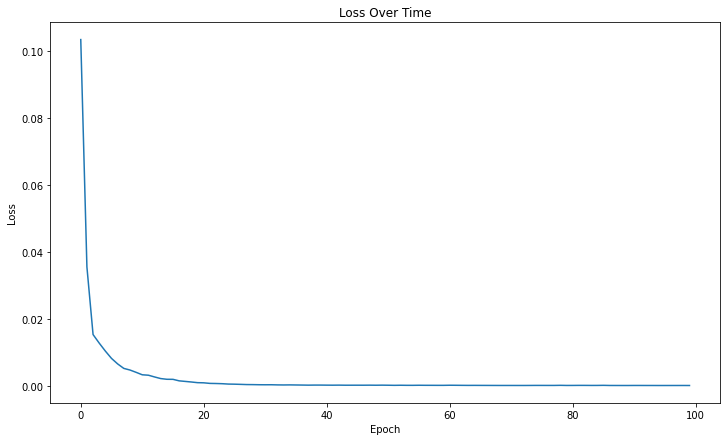

In [46]:
fig, ax = plt.subplots()
x = np.arange(len(loss_list))
y = np.array(loss_list)
ax.plot(x, y)
ax.set_title('Loss Over Time')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
fig.set_size_inches((12,7))
fig.set_facecolor('w')
fig.savefig('Loss.png', dpi=300)

(0.0, 1.0)

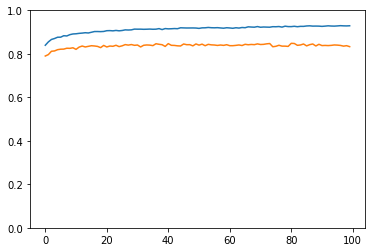

In [41]:
fig, ax = plt.subplots()
ax.plot(x, np.array(acc_train_list))
ax.plot(x, np.array(acc_eval_list))
ax.set_ylim((0,1))

[[-1. -1. -1. ...  0.  0.  0.]
 [-1. -1. -1. ... -1.  1.  1.]
 [-1. -1. -1. ... -1.  0. -1.]
 ...
 [ 0.  0. -1. ... -1. -1. -1.]
 [ 0.  0. -1. ...  0.  1.  1.]
 [-1. -1. -1. ... -1.  0. -1.]]


/media/indirected/Local Disk/University/Work/Metrtic Learning/multilabel-deep-metric/src/DML.py:199: RuntimeWarning: Mean of empty slice
  y_pred_keras_tmp = np.nanmean(y_k_neghbors, axis=1) #y_eval x 1


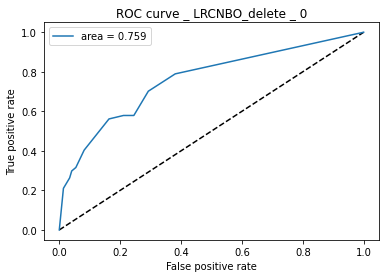

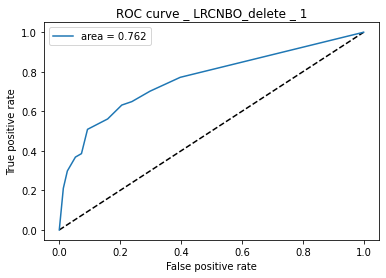

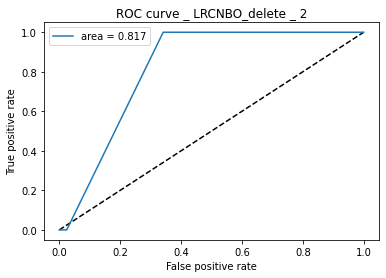

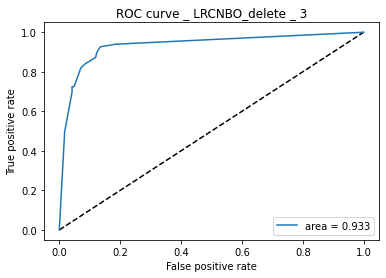

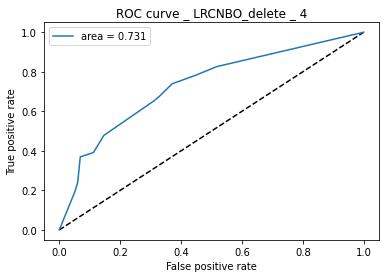

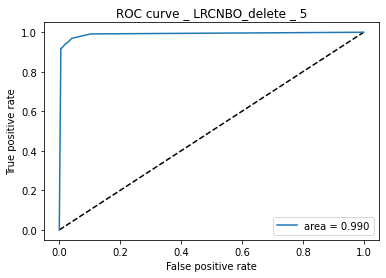

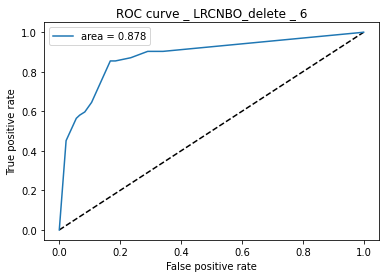

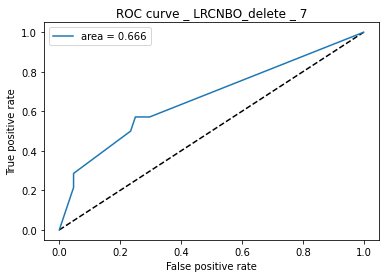

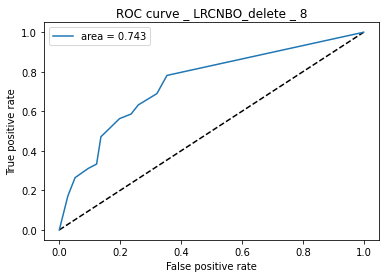

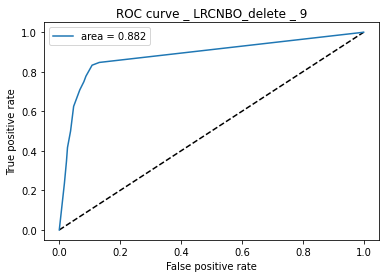

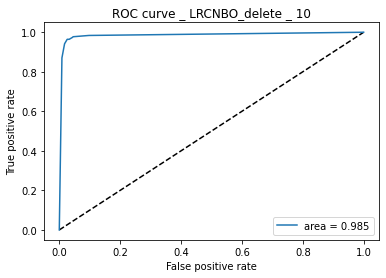

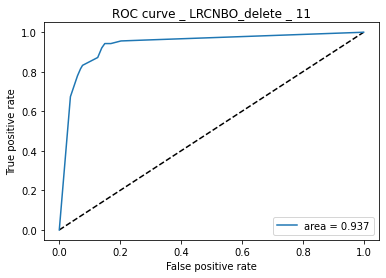

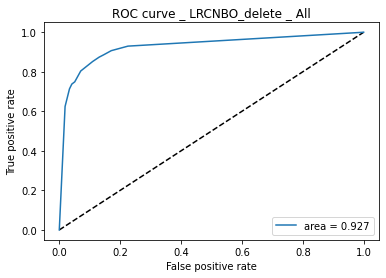

<Figure size 432x288 with 0 Axes>

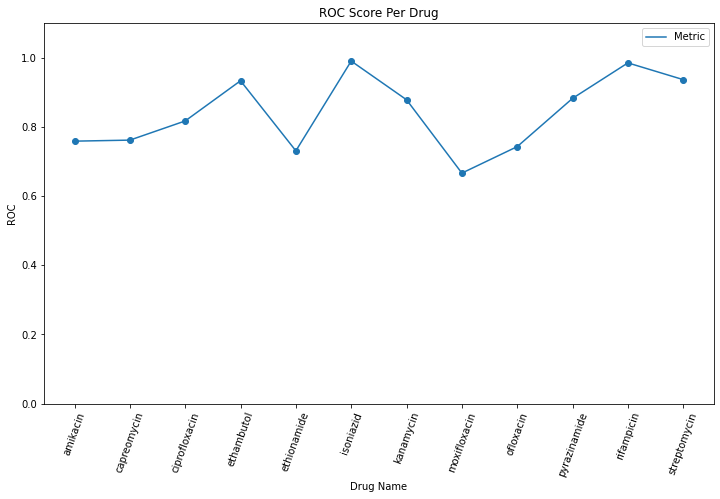

In [44]:
# acc_per_drug = get_acc_per_drug(X_train, Y_train, X_val, Y_val, model, 5)
# acc_per_drug_test = get_acc_per_drug(X_train, Y_train, X_test, Y_test, model, 5)
X_test_ = X_test.copy()
Y_test_ =Y_test.copy()
X_train_=X_train.copy()
Y_train_=Y_train.copy()
score_for_each_drug = DML.ROC(model, X_test_, Y_test_, X_train_, Y_train_, ("LRCN" + "BO_delete"), True)
drug_names = Y.columns[1:].to_numpy()
fig, ax = plt.subplots()
x = np.arange(drug_names.shape[0])
# ax.plot(x, acc_per_drug)
# ax.plot(x, acc_per_drug_test)
ax.plot(x, score_for_each_drug, label='Metric')
ax.scatter(x, score_for_each_drug)
ax.set_xticks(x)
ax.set_ylim((0,1.1))
ax.set_xticklabels(drug_names, rotation=70)
ax.legend()
ax.set_title('ROC Score Per Drug')
ax.set_xlabel('Drug Name')
ax.set_ylabel('ROC')
fig.set_size_inches((12,7))
fig.set_facecolor('w')
fig.savefig('esm.png', dpi=300)

In [165]:
def plot_sim_count(
        X_plt, Y_plt, trained_model, untrained_model, inter_threshold=5, intra_threshold=0, max_points_per_sim=1, weighted_radius=False, custom_anchor_idx=None,
        point_rgb_colors = np.array([[(105,41,196)], [(0,93,93)], [(250,77,86)], [(25,128,56)], [(238,83,139)], [(0,157,154)], [(138,56,0)], [(17,146,232)], [(159,24,83)], [(87,4,8)], [(0,45,156)], [(178,134,0)], [(1,39,73)], [(165,110,255)]])/255,
    ):
    point_rgb_colors_with_alpha = np.pad(point_rgb_colors, ((0,0),(0,0), (0, 1)), constant_values=0.25)
    if custom_anchor_idx is not None:
        maxi = custom_anchor_idx
        maxlen = np.unique(np.sum(Y_plt == Y_plt[maxi], axis=1)).shape[0]
        print('Custom Anchor:')
        print(f'Max Similarity Count: {maxlen}')
        print(f'Custom Anchor Index: {maxi}')
    else:
        # Find a good anchor
        maxlen = 0
        maxi = 0
        Y_plt_maskable = np.ma.array(Y_plt, mask=False)
        for i in tqdm(range(Y_plt.shape[0])):
            Y_plt_maskable.mask[i] = True
            sim_uniq, sim_counts = np.unique(np.sum(Y_plt_maskable == Y_plt[i], axis=1), return_counts=True)
            sim_uniq = sim_uniq.compressed()
            if maxlen < sim_uniq.shape[0] and np.all(sim_counts[:-1] > 10):
                maxlen = sim_uniq.shape[0]
                maxi = i
            Y_plt_maskable.mask[i] = False
        print(f'Max Similarity Count: {maxlen}')
        print(f'Best Anchor Index: {maxi}')


    #Seperate each similarity count
    sim_list_indcs = []
    for i in range(maxlen):
        sim_list_indcs.append(np.where(np.sum(Y_plt == Y_plt[maxi], axis=1) == i)[0])


    #TSNE
    emb_plt = trained_model(torch.from_numpy(X_plt.astype('float32'))).detach().numpy()
    tsne_plt = TSNE(n_components=2, metric='euclidean').fit_transform(emb_plt)

    # Sort indcs w.r.t. their distance from anchor
    for i in range(maxlen): 
        criteria = np.argsort(np.linalg.norm(tsne_plt[sim_list_indcs[i]] - tsne_plt[maxi], axis=1))
        sim_list_indcs[i] = sim_list_indcs[i][criteria]

    #Calculate points radius
    if weighted_radius:
        radius = [sim.shape[0] for sim in sim_list_indcs]
        radius = np.array(radius) / np.sum(radius) * 100000
    else:
        radius = [600 for sim in sim_list_indcs]



    
    # Plot
    fig, ax = plt.subplots()
    #prev_norm = np.linalg.norm(tsne_plt[sim_list_indcs[-1][1]] - tsne_plt[maxi]) - inter_threshold
    prev_norm = 0.01
    ax.scatter(tsne_plt[maxi, 0], tsne_plt[maxi, 1], s=600, c=[(0,0,0, 0.5)], edgecolor=[(0,0,0)], linewidths=2.5)
    ax.annotate('A', (tsne_plt[maxi, 0] - 0.7, tsne_plt[maxi, 1] - 1), fontsize= 18)
    selected_points_dict = {'A': (maxi, X.iloc[maxi, 0])}
    for i in reversed(range(maxlen)):
        for j in range(sim_list_indcs[i].shape[0]):
            current_norm = np.linalg.norm(tsne_plt[sim_list_indcs[i][j]] - tsne_plt[maxi])
            if current_norm >= prev_norm + inter_threshold:
                prev_norm = current_norm
                current_centroid = tsne_plt[sim_list_indcs[i][j]]
                selected_points_dict[i] = (sim_list_indcs[i][j], X.iloc[sim_list_indcs[i][j], 0])
                point_count = 0
                while intra_threshold >= np.linalg.norm(tsne_plt[sim_list_indcs[i][j]] - current_centroid) and point_count < max_points_per_sim:
                    ax.scatter(tsne_plt[sim_list_indcs[i][j], 0], tsne_plt[sim_list_indcs[i][j], 1], s=radius[i], c=point_rgb_colors_with_alpha[i], edgecolors=point_rgb_colors[i], linewidths=2.5)
                    ax.annotate(str(i), (tsne_plt[sim_list_indcs[i][j], 0], tsne_plt[sim_list_indcs[i][j], 1]), fontsize=16, horizontalalignment='center', verticalalignment='center')
                    point_count += 1
                    j += 1
                    if j == sim_list_indcs[i].shape[0]: break
                break
    ax.set_title('Visualization of Points in a Trained Model')
    fig.set_facecolor('w')
    fig.set_size_inches((15,10))
    fig.savefig('tsne_trained.png', dpi=300)



    ####### plot the same points with no train
    #TSNE
    emb_plt = untrained_model(torch.from_numpy(X_plt.astype('float32'))).detach().numpy()
    tsne_plt = TSNE(n_components=2, metric='euclidean').fit_transform(emb_plt)


    fig, ax = plt.subplots()
    #prev_norm = np.linalg.norm(tsne_plt[sim_list_indcs[-1][1]] - tsne_plt[maxi]) - inter_threshold
    for key in selected_points_dict.keys():
        idx = selected_points_dict[key][0]
        ax.scatter(tsne_plt[idx, 0], tsne_plt[idx, 1], s=radius[key] if key != 'A' else 600, c=point_rgb_colors_with_alpha[key] if key != 'A' else [(0,0,0,0.5)], edgecolors=point_rgb_colors[key] if key != 'A' else [(0,0,0)], linewidths=2.5)
        ax.annotate(str(key), (tsne_plt[idx, 0], tsne_plt[idx, 1]), fontsize=16, horizontalalignment='center', verticalalignment='center')
    ax.set_title('Visualization of the Exact Same Points in an Untrained Model')
    fig.set_facecolor('w')
    fig.set_size_inches((15,10))
    fig.savefig('tsne_untrained.png', dpi=300)

    return selected_points_dict

In [40]:
for i in range(Y_mat.shape[0]):
    if np.nansum(Y_mat[i]) == 11:
        break
i

477

  0%|          | 0/7845 [00:00<?, ?it/s]

Max Similarity Count: 12
Best Anchor Index: 1514


/media/indirected/Local Disk/University/Work/Sport Analysis/Prediction_ThesisMethod/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/media/indirected/Local Disk/University/Work/Sport Analysis/Prediction_ThesisMethod/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/media/indirected/Local Disk/University/Work/Sport Analysis/Prediction_ThesisMethod/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/media/indirected/Local Disk/University/Work/Sport Analysis/Prediction_ThesisMethod/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 t

{'A': (1514, 'ERR1873439'),
 11: (1559, 'ERR1873496'),
 10: (1569, 'ERR1873508'),
 9: (3883, 'SRR1159129'),
 8: (7708, 'SRR847799'),
 7: (3559, 'SRR1049032'),
 6: (3560, 'SRR1049036'),
 5: (2669, 'ERR551894'),
 4: (3511, 'SRR1019159'),
 3: (2896, 'ERR552383'),
 2: (2735, 'ERR552020'),
 1: (7800, 'SRR998732'),
 0: (1279, 'ERR181756')}

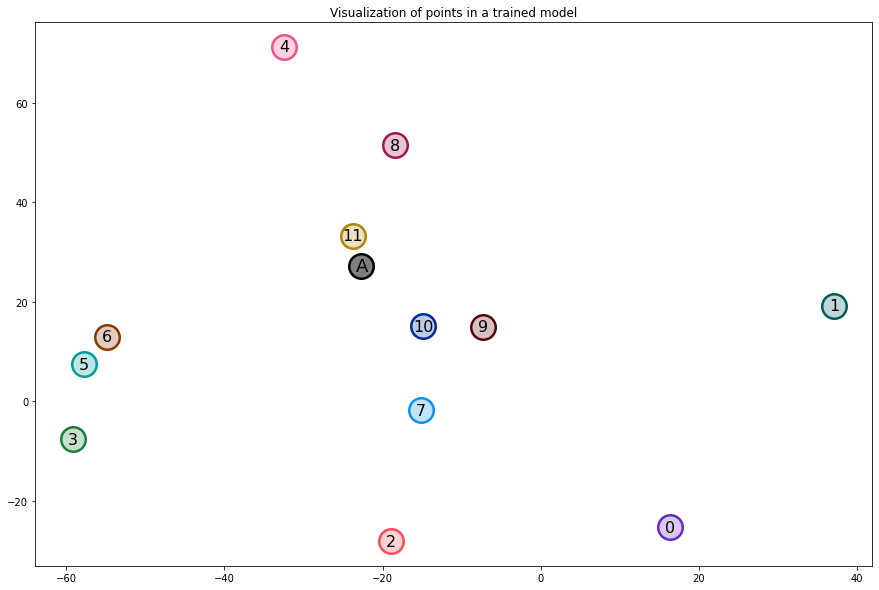

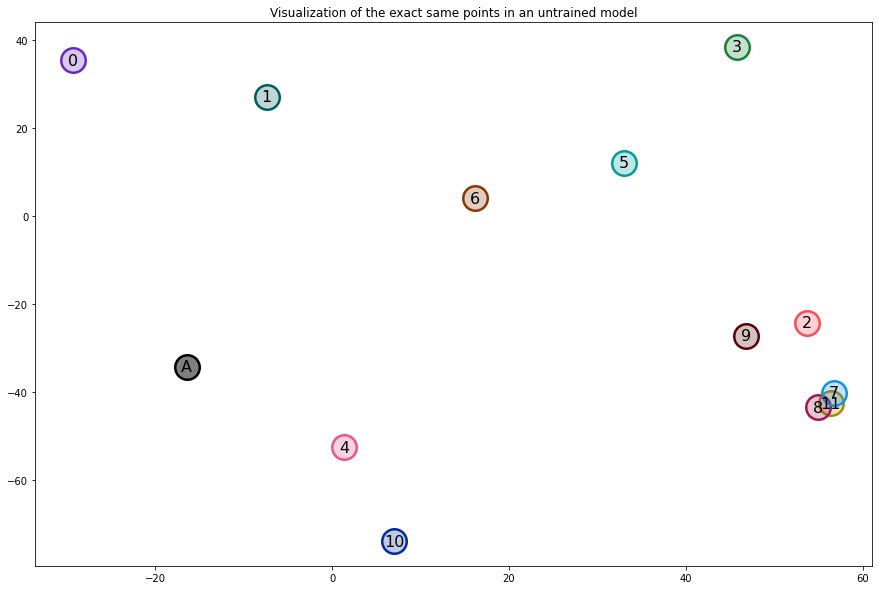

In [164]:
untrained = mymodels.SimpleNet(X_train.shape[1], 30, [X_train.shape[1], 1500, 30])
plot_sim_count(
    X_mat,
    Y_mat,
    model,
    untrained,
    inter_threshold=5,
    intra_threshold=0,
    max_points_per_sim=1,
    weighted_radius=False
)

# PROTOTYPE CODE - NO NEED TO RUN ANYTHING BELOW THIS TEXT

In [64]:
maxlen = 0
maxi = 0
Y_train_maskable = np.ma.array(Y_mat, mask=False)
for i in tqdm(range(Y_mat.shape[0])):
    Y_train_maskable.mask[i] = True
    sim_uniq, sim_counts = np.unique(np.sum(Y_train_maskable == Y_mat[i], axis=1), return_counts=True)
    sim_uniq = sim_uniq.compressed()
    if maxlen < sim_uniq.shape[0] and np.all(sim_counts[:-1] > 10):
        maxlen = sim_uniq.shape[0]
        maxi = i
    Y_train_maskable.mask[i] = False

print(f'Max Similarity Count: {maxlen}')
print(f'Best Anchor Index: {maxi}')

  0%|          | 0/7845 [00:00<?, ?it/s]

Max Similarity Count: 12
Best Anchor Index: 1514


In [65]:
sim_list_indcs = []
for i in range(maxlen):
    sim_list_indcs.append(np.where(np.sum(Y_mat == Y_mat[maxi], axis=1) == i)[0])

In [150]:
Y_mat[1514]

array([ 1.,  1., nan,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [70]:
emb_train = model(torch.from_numpy(X_mat.astype('float32'))).detach().numpy()
tsne_train = TSNE(n_components=2, metric='euclidean').fit_transform(emb_train)

/media/indirected/Local Disk/University/Work/Sport Analysis/Prediction_ThesisMethod/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/media/indirected/Local Disk/University/Work/Sport Analysis/Prediction_ThesisMethod/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [71]:
for i in range(maxlen): 
    criteria = np.argsort(np.linalg.norm(tsne_train[sim_list_indcs[i]] - tsne_train[maxi], axis=1))
    sim_list_indcs[i] = sim_list_indcs[i][criteria]

In [72]:
radius = [sim.shape[0] for sim in sim_list_indcs]
radius = np.array(radius) / np.sum(radius) * 100000

In [43]:
np.linalg.norm(tsne_train[sim_list_indcs[11]] - tsne_train[maxi], axis=1)

array([ 0.       ,  5.3722725,  6.7231317,  9.94017  , 26.153208 ,
       32.5055   , 52.45521  , 62.0804   , 62.23502  , 62.845524 ,
       62.88037  , 63.003006 , 63.149498 , 63.371532 , 64.06537  ,
       64.33446  ], dtype=float32)

In [73]:
model(torch.tensor(X_mat[[maxi]].astype('float32')))

tensor([[0.0000, 0.2375, 0.0000, 0.1992, 0.0000, 0.2384, 0.2410, 0.3358, 0.0000,
         0.0000, 0.1498, 0.0000, 0.0000, 0.2898, 0.2866, 0.4301, 0.3338, 0.2481,
         0.0000, 0.0000, 0.0000, 0.2069, 0.0000, 0.0000, 0.0000, 0.0948, 0.2072,
         0.0000, 0.0000, 0.1870]], grad_fn=<DivBackward0>)

In [185]:
mmmm = copy.deepcopy(model)
for layer in mmmm.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

In [186]:
mmmm(torch.tensor(X_mat[[maxi]].astype('float32')))

tensor([[0.2344, 0.2003, 0.2266, 0.0955, 0.1925, 0.2575, 0.3010, 0.2358, 0.0000,
         0.2829, 0.0000, 0.0000, 0.1640, 0.0000, 0.2036, 0.2559, 0.0000, 0.2650,
         0.0000, 0.2030, 0.2660, 0.0000, 0.0000, 0.0000, 0.0000, 0.2301, 0.2551,
         0.0000, 0.2843, 0.0000]], grad_fn=<DivBackward0>)

In [157]:
tsne_train.shape

(7845, 2)

In [160]:
tsne_train[maxi]

array([-25.64416 ,  59.616642], dtype=float32)

In [161]:
tsne_train[sim_list_indcs[11][1]]

array([-24.919777,  50.299706], dtype=float32)

In [170]:
np.all(X_mat[maxi] == X.iloc[maxi, 1:].to_numpy())

True

In [163]:
X_mat[maxi]

array([0, 0, 1, ..., 0, 0, 0])

In [172]:
X.iloc[maxi, 0]

'ERR1873439'

In [74]:
point_rgb_colors = [[(105,41,196)], [(0,93,93)], [(250,77,86)], [(25,128,56)], [(238,83,139)], [(0,157,154)], [(138,56,0)], [(17,146,232)], [(159,24,83)], [(87,4,8)], [(0,45,156)], [(178,134,0)], [(1,39,73)], [(165,110,255)]]
point_rgb_colors = np.array(point_rgb_colors)/255
point_rgb_colors_with_alpha = np.pad(point_rgb_colors, ((0,0),(0,0), (0, 1)), constant_values=0.25)
another_color_palette = np.array([[(0,63,92)], [(47,75,124)], [(102,81,145)], [(160,81,149)], [(212,80,135)], [(249,93,106)], [(255,124,67)], [(255,166,0)]])/255

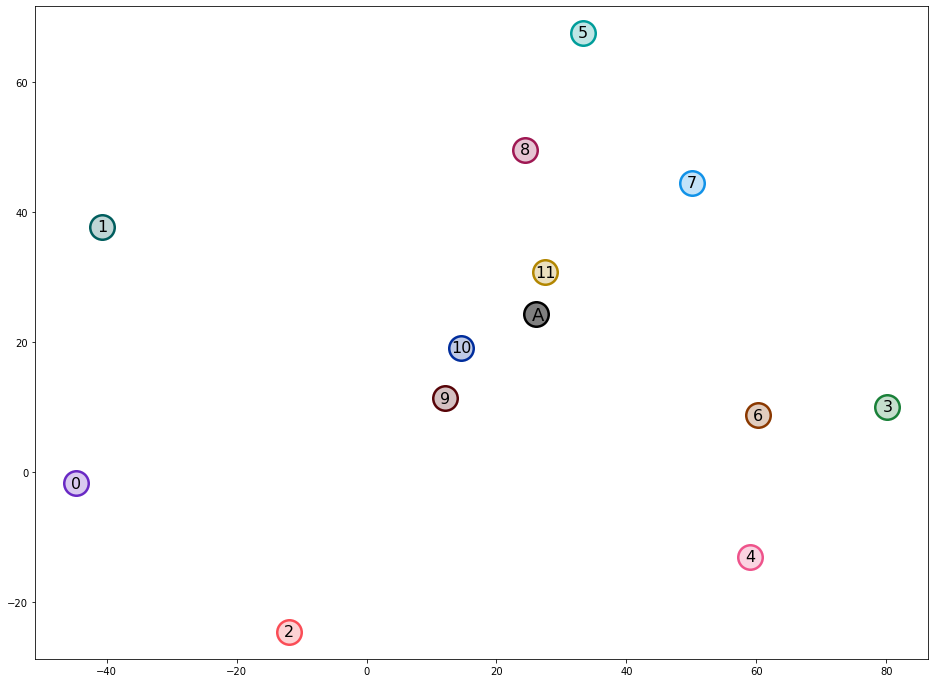

In [110]:
fig, ax = plt.subplots()
threshold = 6
prev_norm = np.linalg.norm(tsne_train[sim_list_indcs[-1][1]] - tsne_train[maxi]) - threshold
prev_norm = 0.01
threshold2 = 0
max_points = 1
colors = ['bisque', 'forestgreen', 'slategrey', 'royalblue', 'lawngreen', 'red', 'magenta', 'cyan', 'gold', 'lime', 'peru', 'indigo']
ax.scatter(tsne_train[maxi, 0], tsne_train[maxi, 1], s=600, c=[(0,0,0, 0.5)], edgecolor=[(0,0,0)], linewidths=2.5)
ax.annotate('A', (tsne_train[maxi, 0] -0.7, tsne_train[maxi, 1]-1), fontsize= 18)
selected_points_dict = {'A': X.iloc[maxi, 0]}
for i in reversed(range(maxlen)):
    for j in range(sim_list_indcs[i].shape[0]):
        current_norm = np.linalg.norm(tsne_train[sim_list_indcs[i][j]] - tsne_train[maxi])
        if current_norm >= prev_norm + threshold:
            prev_norm = current_norm
            current_centroid = tsne_train[sim_list_indcs[i][j]]
            selected_points_dict[i] = X.iloc[sim_list_indcs[i][j], 0]
            point_count = 0
            while threshold2 >= np.linalg.norm(tsne_train[sim_list_indcs[i][j]] - current_centroid) and point_count < max_points:
                ax.scatter(tsne_train[sim_list_indcs[i][j], 0], tsne_train[sim_list_indcs[i][j], 1], s=600, c=point_rgb_colors_with_alpha[i], edgecolors=point_rgb_colors[i], linewidths=2.5)
                ax.annotate(str(i), (tsne_train[sim_list_indcs[i][j], 0], tsne_train[sim_list_indcs[i][j], 1]), fontsize=16, horizontalalignment='center', verticalalignment='center')
                # ax.text(tsne_train[sim_list_indcs[i][j], 0], tsne_train[sim_list_indcs[i][j], 1],str(i), fontsize=16,horizontalalignment='center', verticalalignment='center')
                point_count += 1
                j += 1
                if j == sim_list_indcs[i].shape[0]:
                    break
            break
ax.axis('equal')
#ax.set_aspect('equal', adjustable='box', anchor='NW')
fig.set_facecolor('w')
fig.set_size_inches((16,12))
fig.savefig('tsne.png', dpi=300)

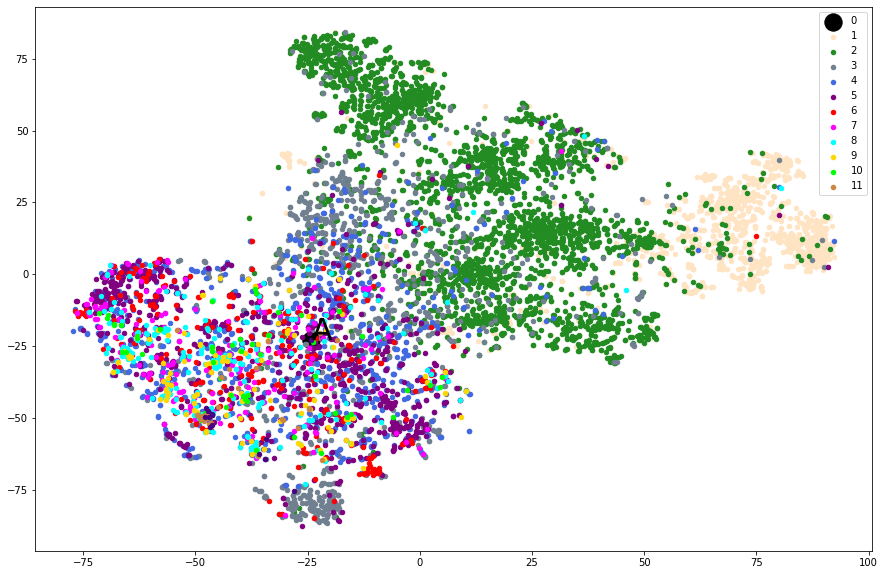

In [54]:
fig, ax = plt.subplots()

ax.scatter(tsne_train[maxi, 0], tsne_train[maxi, 1], s=300, c='black')
ax.annotate('A', (tsne_train[maxi, 0], tsne_train[maxi, 1]), fontsize= 30)
colors = ['bisque', 'forestgreen', 'slategrey', 'royalblue', 'purple', 'red', 'magenta', 'cyan', 'gold', 'lime', 'peru', 'indigo']
for i in range(maxlen):        
    ax.scatter(tsne_train[sim_list_indcs[i][:], 0], tsne_train[sim_list_indcs[i][:], 1], s=20, c=colors[i])
    #ax.annotate(str(i), (tsne_train[sim_list_indcs[i][0], 0], tsne_train[sim_list_indcs[i][0], 1]), fontsize=20)
ax.legend([str(i) for i in range(maxlen)])
fig.set_size_inches((15,10))